<a href="https://colab.research.google.com/github/dtegegn/deepdream/blob/master/Seletech_dati_normalizzati_puri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Seletech classificazione dati normalizzati di materiali puri</h1>



# Import Google Drive

In [0]:
!pip install tensorflow==2
!pip install tqdm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [0]:
import pandas as pd
import numpy as np 

from keras import optimizers 
#from keras.models import Sequential 
#from keras.layers import Dense
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from keras.utils import np_utils

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import LabelEncoder 
from sklearn.pipeline import Pipeline 
import matplotlib.pylab as plt 
from sklearn.model_selection import train_test_split 

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
import time

import tensorflow as tf 



# Load Dataset

In [23]:
# load dataset
dataframe = pd.read_csv("/content/drive/My Drive/Seletech/table/tablePureNormMaterial.csv", header=None)
dataset = dataframe.values
X = dataset[:,0:702].astype(float)
Y = dataset[:,702]
print(dataset.shape)

(7200, 703)


## Split dataset

In [4]:
print(X.shape)
print(Y.shape)
print(np.unique(Y))

X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2)

print("\nX_train:\n")
print(X_train.shape)
print(y_train.shape)
print("\nX_test:\n")
print(X_test.shape)


(7200, 702)
(7200,)
['BabyMilk' 'Cocoa' 'CornFlour' 'CornStarch' 'PotatoStarch' 'RiceStarch'
 'Sugar' 'WheatStarch']

X_train:

(5760, 702)
(5760,)

X_test:

(1440, 702)


In [5]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

print(dummy_y.shape)

(5760, 8)


In [6]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y)

print(dummy_y_test.shape)

(1440, 8)


# Grid Search

In [0]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
	# create model
	grid_model = Sequential()
	grid_model.add(Dense(8, input_dim=702, kernel_initializer=init, activation='relu'))
	grid_model.add(Dense(256, kernel_initializer=init, activation='relu'))
	grid_model.add(Dense(8, kernel_initializer=init, activation='softmax'))
	# Compile model
	grid_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
	return grid_model

In [39]:
 # fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
grid_model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best: 0.953646 using {'batch_size': 5, 'epochs': 150, 'init': 'normal', 'optimizer': 'adam'}
0.118403 (0.001299) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.891319 (0.044845) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.773264 (0.097702) with: {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'rmsprop'}
0.644097 (0.370742) with: {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'adam'}
0.391840 (0.386947) with: {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.392014 (0.387192) with: {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'adam'}
0.332639 (0.303959) with: {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.639931 (0.370293) with: {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.344444 (0.320654) with: {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optim

In [43]:
from sklearn.metrics import classification_report,confusion_matrix
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, grid.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

    BabyMilk       0.97      1.00      0.98       179
       Cocoa       1.00      1.00      1.00       182
   CornFlour       1.00      0.97      0.98       186
  CornStarch       0.87      0.80      0.83       171
PotatoStarch       1.00      1.00      1.00       176
  RiceStarch       0.98      1.00      0.99       194
       Sugar       1.00      1.00      1.00       174
 WheatStarch       0.83      0.89      0.86       178

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440




In [46]:

print('Confusion Matrix')
print(confusion_matrix(y_pred,y_true))

Confusion Matrix
[[179   0   6   0   0   0   0   0]
 [  0 182   0   0   0   0   0   0]
 [  0   0 180   0   0   0   0   0]
 [  0   0   0 136   0   0   0  20]
 [  0   0   0   0 176   0   0   0]
 [  0   0   0   3   0 194   0   0]
 [  0   0   0   0   0   0 174   0]
 [  0   0   0  32   0   0   0 158]]


# Create Model

In [0]:
def baseline_model():
  #create model
  model= Sequential()
  model.add(Dense(8, input_dim=702, activation = 'relu'))
  model.add(Dense(8, activation='softmax'))
  #compile model
  with tf.device('/GPU:0'):
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
  return model

# Train Model




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 5624      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
Total params: 5,696
Trainable params: 5,696
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5760 samples, validate on 1440 samples
Epoch 1/200





5760/5760 [==============================] - 5s 898us/step - loss: 2.0682 - acc: 0.1503 - val_loss: 2.0266 - val_acc: 0.2208
Epoch 2/200
5760/5760 [==============================] - 1s 110us/step - loss: 2.0035 - acc: 0.2194 - val_loss: 1.9718 - val_acc: 0.2271
Epoch 3/200
5760/5760 [==============================] - 1s 96us/step - loss: 1.9520 

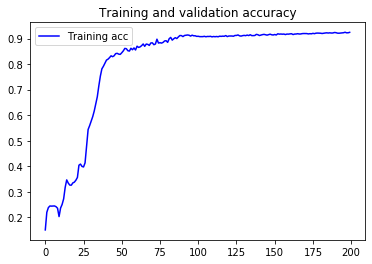

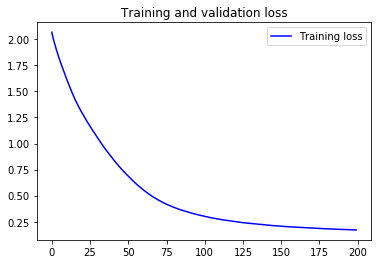

In [0]:
# Compile the model
model = baseline_model()
model.summary()

with tf.device('/GPU:0'):
  model.compile(loss='categorical_crossentropy',
               optimizer=optimizers.RMSprop(lr=1e-4), 
               metrics=['acc'])

# Train the Model
with tf.device('/GPU:0'):
  history = model.fit(x=X_train, 
                      y=dummy_y, 
                      validation_data = (X_test,dummy_y_test),
                      batch_size=30, 
                      epochs=200, 
                      verbose=1
                      )

# Save the Model
#model.save('/content/drive/My Drive/artigianale.h5')

# Plot the accuracy and loss curves
acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




# Evaluate Model

In [0]:
print(model.evaluate_generator(generator = X_train, verbose=1))
print(model.evaluate_generator(generator = validation_generator, verbose=1))
print(model.evaluate_generator(generator = test_generator, verbose=1))

NameError: ignored

# Test Model

In [0]:

y_pred = model.predict(X_test)
predicted_classes = np.argmax(y_pred ,axis=1)
print(y_test.shape)
print(y_pred.shape)
print(predicted_classes.shape)

(1440,)
(1440, 8)
(1440,)


In [0]:
from keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix



# Get the filenames from the generator

# Get the ground truth from generator
ground_truth = dummy_y_test



# Get the predictions from the model using the generator


errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),len(X_test)))


print('Confusion Matrix')
print(confusion_matrix(y_pred.argmax(axis=1),predicted_classes))
print('Classification Report')
target_names = numpy.unique(Y)
print(classification_report(y_pred.argmax(axis=1),predicted_classes, target_names=target_names))


In [0]:


estimator = KerasClassifier(build_fn=baseline_model, epochs=150, batch_size=10, verbose=0)

# K-fold Validation

In [0]:
kfold = KFold(n_splits=5, shuffle=True)

In [0]:
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 87.97% (5.53%)


In [0]:
results[1]

0.8340277780985667